# Informal Settlements

# 1_ Entrenamiento

   El modelo de ML utiliza para entrenar un dataset compuesto por imágenes y máscaras para el entrenamiento. Estas ultimas son imagenes binarias que delimitan el objeto de interés, 1 donde esta y 0 donde no. 

In [24]:
#!pip install pysatproc

In [2]:
from unetseg.train import TrainConfig, train
from unetseg.evaluate import plot_data_generator
import os

In [3]:
#General
YEAR = "2020"

ZONE = "sula"
RESO = "low"

BUCKET_IMG = f"gs://dym-quilmes-trucks-temp/I2UD/imagenes/{ZONE}/{RESO}/{YEAR}/*.tif" #CHECK

BASE_PATH = "./.."
PATH_TRAIN_IMAGES = f'/images/{ZONE}/{RESO}/'

In [4]:
if ZONE == "sula":

    SIZE =130
    STEP_SIZE = 40
    #satproc
    GT_FILE = "annotations_sula2.gpkg" 
    CLASSES = 'A'
    #train
    INFO = "classA"
    #unet
    CLASS_WEIGHT = [1]
    STEP_PER_EPOCH = 100
    N_CLASSES = 1
    VERSION='v3' #reentreno de v2 con early stop pacience= 10
    
if ZONE == "tegu":

    SIZE =80
    STEP_SIZE = 40
    #satproc
    GT_FILE = "anotaciones_lowresolution_small_4326.geojson"
    CLASSES = 'A' 'B' 'C'
    ##train
    INFO = "classABC_gtlowreso"
    ##unet
    CLASS_WEIGHT = [0.2,0.3,0.5]
    STEP_PER_EPOCH = 100
    N_CLASSES = 3
  
    
if RESO =="low":
    
    RESCALE_MODE = "values --min 0 --max 0.3"


   
## Generacion del data set de entrenamiento

   En esta etapa generamos el dataset de entrenamiento mediante el uso de **GDAL** y **Satproc**. Primero descargamos las imagenes satelitales y utilizamos GDAL para quedarnos con la combinacion de bandas deseada. Luego Utilizamos satproc para generar el dataset con todas las caracteristicas necesarias para el modelo: tamaño , cantidad de imagenes, rango de valores, etc.

Descargamos las imágenes del bucket

In [4]:
folder = BASE_PATH + PATH_TRAIN_IMAGES
!mkdir -p $folder

!gsutil -m cp -r $BUCKET_IMG   $folder

Copying gs://dym-quilmes-trucks-temp/I2UD/imagenes/sula/low/2020/0000000000-0000000000.tif...
\ [1/1 files][906.9 MiB/906.9 MiB] 100% Done  53.1 MiB/s ETA 00:00:00           
Operation completed over 1 objects/906.9 MiB.                                    


Podemos verificar que los archivos fueron correctamente descargados

In [5]:
!ls $folder

0000000000-0000000000.tif


### Satproc

Con la herramienta **satproc_extract_chips** se generan, a partir de las imágenes descargadas del bucket, imágenes (chips) generalmente mas pequeñas y máscaras (utilizando las anotaciones de verdad de campo).

**OBS** : tanto las imagenes como el archivo vectorial deben tener la misma georeferencia, por ejemplo 4326

In [5]:
path_to_files= f'{BASE_PATH}{PATH_TRAIN_IMAGES}*.tif' #carpeta a las imagenes
output_folder= os.path.join('/home/ro/I2UD/ai-climate-informal-settlements/dataset/data_train/',ZONE,RESO,YEAR,str(SIZE)+'_'+str(STEP_SIZE)+'/') #carpeta de destino del dataset
vector_file = f'{BASE_PATH}/data/shp/gt/{GT_FILE}' # archivo vectorial de verdad de campo
vector_file_aoi = vector_file #archivo vectorial con las zonas de interes

In [7]:
output_folder

'/home/ro/I2UD/ai-climate-informal-settlements/dataset/data_train/sula/low/2020/130_40/'

Ejecutamos satproc

In [20]:
#!satproc_extract_chips --help


In [21]:
!satproc_extract_chips \
                $path_to_files \
                -o $output_folder \
                --size $SIZE \
                --step-size $STEP_SIZE \
                --aoi $vector_file_aoi \
                --labels $vector_file \
                --label-property 'class' \
                --classes $CLASSES \
                --rescale \
                --rescale-mode $RESCALE_MODE

Rasters: 100%|####################################| 1/1 [00:10<00:00, 10.85s/it]


###### Los argumentos:

* **path_to_files** es la ruta a las imágenes 

* **o** es la ruta de destino 

Recomendamos que dicha ruta sea descriptiva, por ejemplo “data_train/120_40/ ” describe : Data_train → datos usados para entrenar; 120_40 → <tamaño de la imagen >_ <tamaño del step-size> 

* **size** tamaño de las imágenes resultantes o chips (las imágenes son cuadradas) 
* **step-size** paso del proceso. Debe ser menor o igual a *size*. Si *step-size* es igual que el *size* entonces no hay overlap en las imágenes resultantes. 

En ocaciones es útil para el entrenamiento generar los chips con un overlap de este modo tenemos más datos para entrenar. 


* **label-property** nombre del campo donde se define cada categoría (solo se usa para el entrenamiento) 

* **classes** nombres de las clases (como aparecen en el geojson), separados por espacios

* **aoi** ruta al archivo vectorial donde están definidas las anotaciones. Al definir una region de interés solo se procesan las imágenes que interceptan esas anotaciones.

* **rescale** lleva los valores de las bandas a 0-255 

Este comando va a generar dos carpetas en la ruta de destino : “images” y “extent”. Los archivos de la primera van a ser de tipo Tiff de 3 bandas (rgb) y los de la segunda van a ser, también, de tipo Tiff pero de N bandas donde N representa el número de clases, en este caso sólo una. Y donde cada una de las bandas es una máscara binaria


## Entrenamiento

Generamos el entrenamiento del modelo utilizando los datasets creados en el paso previo. El modelo es una red neuronal CNN basado en la arquitectura U-Net. Este considera las imágenes y las máscaras binarias como inputs y genera una imagen con la probabilidad de encontrar al objeto de interés.

En esta etapa debemos definir la configuración del modelo de ML.

In [8]:
model_name = f'UNet_{ZONE}_160x160_{str(SIZE)}_{str(STEP_SIZE)}_spe{str(STEP_PER_EPOCH)}_3N_fecha{YEAR}_{INFO}_{VERSION}.h5'

In [9]:
model_name

'UNet_sula_160x160_130_40_spe100_3N_fecha2020_classA_v3.h5'

In [10]:
config = TrainConfig(width   = 160,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc; y no menor a 80)
                     height  = 160,
                     n_channels   = 3,  #  número de canales de la imagen, rgb -> 3
                     n_classes    = N_CLASSES, # número de clases a clasificar
                     apply_image_augmentation = True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes (rotación,)
                     seed       = 42,
                     epochs     = 20, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size = 16, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch  = STEP_PER_EPOCH, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience  = 10, # a medida que entrena se guardan los resultados del entrenamiento despues de cada epoch, si el error no varió luego de ¿¿10 ?? iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split   = 0.1, # se divide la muestra en training (80% de los datos) y validation (20% de los datos) para calcular el error durante el proceso de entrenamiento
                     test_split         = 0.1, # Cantidad de imágenes del dataset
                     images_path        = output_folder,#ruta a las imágenes generadas con Satproc
                     model_path         = os.path.join(BASE_PATH,'data/weights/', model_name),#  ruta del modelo entrenado
                     model_architecture = 'unet',
                     evaluate           = True  ,
                     class_weights      = CLASS_WEIGHT) 

*Obs*: Es util usar un nombre para el archivo de pesos que de información sobre los parametros de entrenamiento. por ejemplo: < modelo >_< proyecto >_< dim_de_las_imagenes >_< size >_< step_size >_< step_per_epoch >.h5 o similares

Podemos visualizar alguna de las imágenes y máscaras del dataset de entrenamiento. A la izquierda se muestra la imágen y a la derecha la máscara 

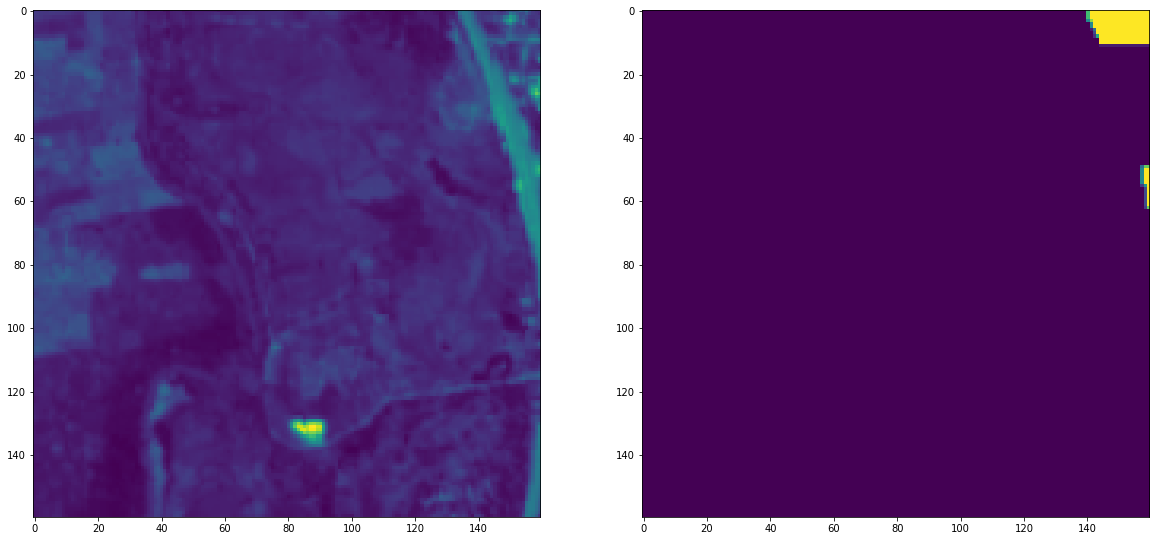

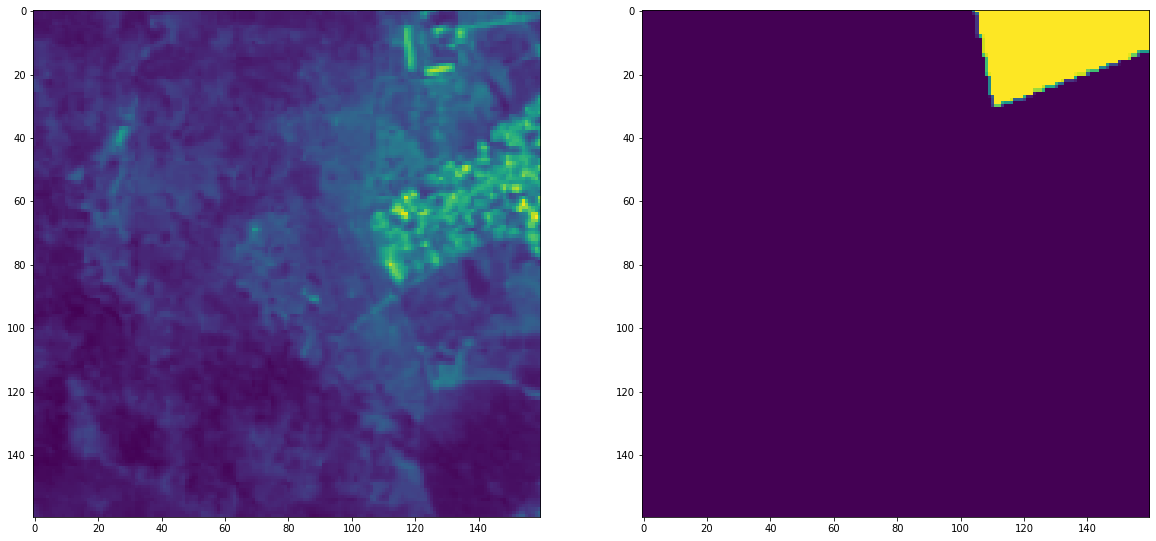

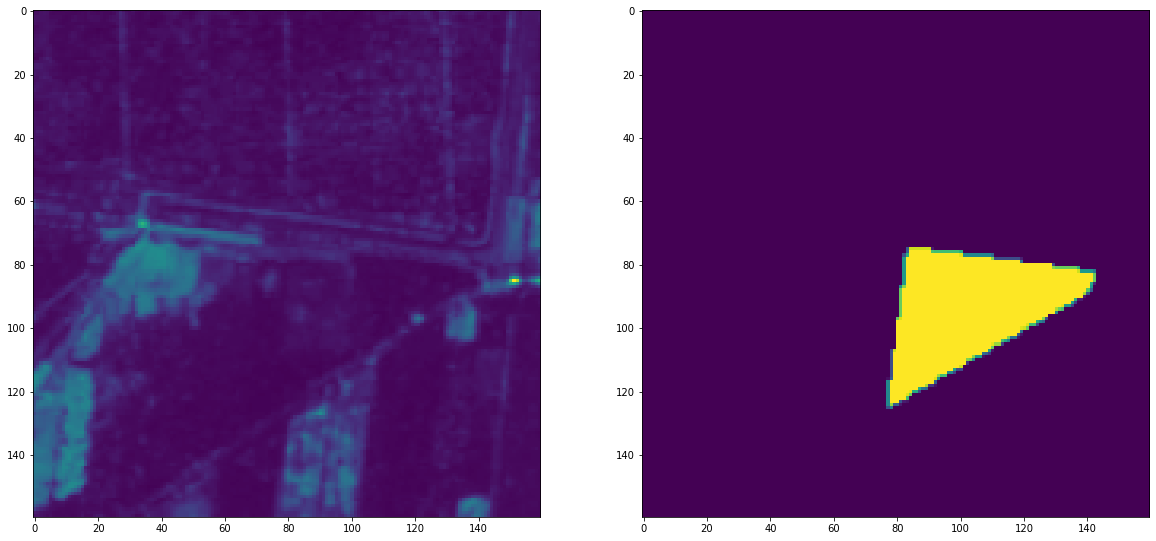

In [11]:
plot_data_generator(num_samples=3, fig_size=(20, 20), train_config=config,img_ch =3)

Corremos el entrenamiento.

In [12]:
res_config = train(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 9248        conv2d[0][0]                     
________________________________________________________________________________

2022-06-01 13:39:20.159797: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-06-01 13:39:20.186045: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2022-06-01 13:39:20.187262: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bd63806410 executing computations on platform Host. Devices:
2022-06-01 13:39:20.187280: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-06-01 13:39:20.202517: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2022-06-01 13:39:20.265404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 13:39:20.265994: I tensorflow/core/common_runtime/g

Epoch 1/20
 99/100 [============================>.] - ETA: 6s - loss: 0.1692 - mean_io_u: 0.4826 
Epoch 00001: val_loss improved from inf to 0.24539, saving model to ./../data/weights/UNet_sula_160x160_130_40_spe100_3N_fecha2020_classA_v3.h5
100/100 [==============================] - 690s 7s/step - loss: 0.1690 - mean_io_u: 0.4826 - val_loss: 0.2454 - val_mean_io_u: 0.4813
Epoch 2/20
 99/100 [============================>.] - ETA: 6s - loss: 0.1437 - mean_io_u: 0.4831 
Epoch 00002: val_loss improved from 0.24539 to 0.19702, saving model to ./../data/weights/UNet_sula_160x160_130_40_spe100_3N_fecha2020_classA_v3.h5
100/100 [==============================] - 682s 7s/step - loss: 0.1435 - mean_io_u: 0.4831 - val_loss: 0.1970 - val_mean_io_u: 0.4792
Epoch 3/20
 99/100 [============================>.] - ETA: 6s - loss: 0.1352 - mean_io_u: 0.4827 
Epoch 00003: val_loss improved from 0.19702 to 0.13938, saving model to ./../data/weights/UNet_sula_160x160_130_40_spe100_3N_fecha2020_classA_v3.h

*** Final  metrics ***
Loss: 0.13943775104624884
Mean IoU: 0.4840006

v3:
*** Final  metrics ***
Loss: 0.11489161103963852
Mean IoU: 0.48463345

Graficamos las métricas generadas.

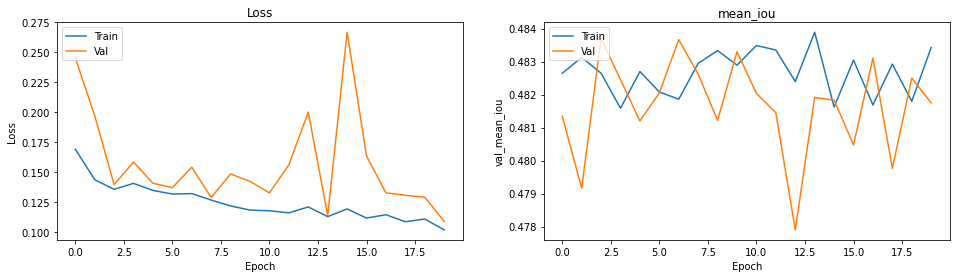

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_config.history['loss'])
plt.plot(res_config.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_config.history['mean_io_u'])
plt.plot(res_config.history['val_mean_io_u'])
plt.title('mean_iou')
plt.ylabel('val_mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.show()
